In [1]:
import base64
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings

warnings.simplefilter(action = 'ignore', category = FutureWarning)

# Preprocessing Functions

In [3]:
def decode_base64(item):
    return base64.b64decode(item.encode()).decode('utf-8')

In [4]:
def decode_human_ai_hash(df):
    df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])
    df = df.applymap(lambda x: x.replace('\xa0', '').strip() if isinstance(x, str) else x)
    df['hash'] = df['hash'].apply(decode_base64)
    df['REQID_ex'] = df['hash'].str.split('__________').str[0]
    df['author'] = df['hash'].str.split('__________').str[-1]
    df.drop(columns = ['hash'], inplace = True)

    nan_summary = df.isnull().sum()
    print("Number of NaN values in each column:\n", nan_summary)
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            majority_value = df[column].mode()[0]
            df[column].fillna(majority_value, inplace = True)
    return df

In [5]:
participants = ['p1', 'p2', 'p3', 'p4']

human_assessed_requirements = [pd.read_excel(f'./{i}_human_evaluation/tasks_b_and_c/task_b.xlsx') for i in participants]
human_assessed_requirements = [decode_human_ai_hash(df) for df in human_assessed_requirements]

Number of NaN values in each column:
 requirement                                                                                                        0
Based on the style and content of the requirement, do you believe it was written by a human or generated by AI?    0
This requirement is well-structured according to the ISO-29248 recommended syntax.                                 0
The use of signaling keywords to indicate the presence of a requirement is appropriate based on ISO-29148.         0
REQID_ex                                                                                                           0
author                                                                                                             0
dtype: int64
Number of NaN values in each column:
 requirement                                                                                                        0
Based on the style and content of the requirement, do you believe it was written by a human 

In [6]:
likert_label2id = {
    'Strongly Disagree': 1,
    'Disagree': 2,
    'Neutral': 3,
    'Agree': 4,
    'Strongly Agree': 5
}

ai_human_label2id = {
    'Zephyr': 0,
    'ReqBrain': 1
}

likert_id2label = {v: k for k, v in zip(likert_label2id.keys(), likert_label2id.values())}
ai_human_id2label = {v: k for k, v in zip(ai_human_label2id.keys(), ai_human_label2id.values())}

In [7]:
human_assessed_requirements_concated = pd.concat(human_assessed_requirements, axis = 0)
human_ai, syntax_quality, keyword_quality = human_assessed_requirements_concated.columns[1:-2]

In [8]:
human_assessed_requirements_concated['author'] = human_assessed_requirements_concated['author'].replace('AI', 'ReqBrain')
human_assessed_requirements_concated['author'] = human_assessed_requirements_concated['author'].replace('UAI', 'Zephyr')

In [9]:
# # mapping labels to id mapping

human_assessed_requirements_concated['author_numeric'] = human_assessed_requirements_concated['author'].map(ai_human_label2id)
human_assessed_requirements_concated[syntax_quality] = human_assessed_requirements_concated[syntax_quality].map(likert_label2id)
human_assessed_requirements_concated[keyword_quality] = human_assessed_requirements_concated[keyword_quality].map(likert_label2id)
human_assessed_requirements_concated.head(3)

,requirement,"Based on the style and content of the requirement, do you believe it was written by a human or generated by AI?",This requirement is well-structured according to the ISO-29248 recommended syntax.,The use of signaling keywords to indicate the presence of a requirement is appropriate based on ISO-29148.,REQID_ex,author,author_numeric
0,The communication interface of the medical dev...,AI,2,1,56111,Zephyr,0
1,The product shall provide the ability to defin...,AI,5,2,2607,ReqBrain,1
2,If ifr Conditions change by 500ft or reset tim...,AI,1,2,43101,ReqBrain,1


# Descriptive Statistics (not shown on the paper)

In [10]:
# Ploting Likert percentage frequencies 
import plot_likert

def prepare_data_for_likert_precentage_scale_plot(df, likert_columns, filter_distro):
    select_ai = filter_distro[0]
    select_hu = filter_distro[1]
    syntax_quality = likert_columns[0]
    keyword_quality = likert_columns[1]

    # Filter HUMAN
    q1_hu_authored_syntax = df[df['author_numeric'] == ai_human_label2id[select_hu]][syntax_quality]
    q2_hu_authored_skeyword = df[df['author_numeric'] == ai_human_label2id[select_hu]][keyword_quality]
    
    # Filter AI
    q1_ai_authored_syntax = df[df['author_numeric'] == ai_human_label2id[select_ai]][syntax_quality]
    q2_ai_authored_skeyword = df[df['author_numeric'] == ai_human_label2id[select_ai]][keyword_quality]

    hu_ai_syntax = {
        'ReqBrain': [likert_id2label[i] for i in q1_hu_authored_syntax],
        'Zephyr': [likert_id2label[i] for i in q1_ai_authored_syntax]
    }
    hu_ai_keyword = {
        'ReqBrain': [likert_id2label[i] for i in q2_hu_authored_skeyword],
        'Zephyr': [likert_id2label[i] for i in q2_ai_authored_skeyword]
        }
    hu_ai_syntax_df = pd.DataFrame(hu_ai_syntax)
    hu_ai_keyword_df = pd.DataFrame(hu_ai_keyword)
    
    return hu_ai_syntax_df, hu_ai_keyword_df

In [11]:
human_ai_q1, human_ai_q2 = prepare_data_for_likert_precentage_scale_plot(human_assessed_requirements_concated,
                                                                         likert_columns = [syntax_quality, keyword_quality],
                                                                         filter_distro = ['Zephyr', 'ReqBrain'])

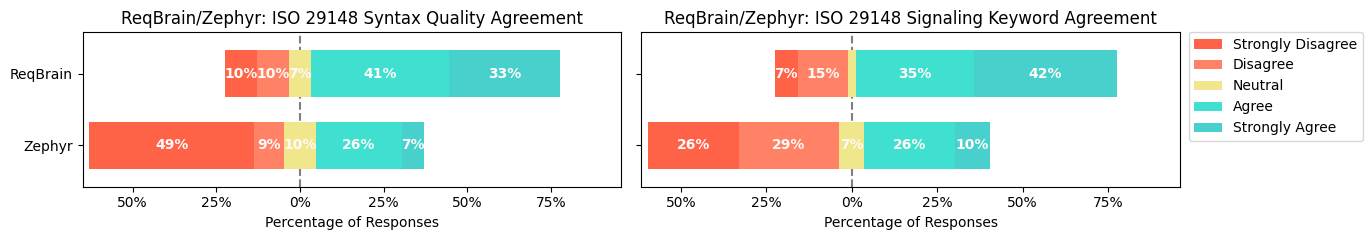

In [12]:
plot_likert.__internal__.BAR_LABEL_FORMAT = "%.0f"

# Setup some config for plot
scale = likert_label2id.keys()
my_color_scheme = [
    plot_likert.colors.TRANSPARENT,
    '#FF6347',  # Tomato (strong disagreement)
    '#FF8266',  # Lighter tomato
    '#F0E68C',  # Khaki (neutral color matching both)
    '#40E0D0',  # Turquoise
    '#48D1CC'   # Medium Turquoise (strong agreement)
]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 2.5))
ax1.set_title("ReqBrain/Zephyr: ISO 29148 Syntax Quality Agreement")
plot_likert.plot_likert(human_ai_q1, scale, plot_percentage = True,
                        bar_labels = True, 
                        bar_labels_color = "snow", 
                        colors = my_color_scheme,
                        ax = ax1,
                        legend = 0,
                        width = 0.65)

ax2.set_title("ReqBrain/Zephyr: ISO 29148 Signaling Keyword Agreement")
plot_likert.plot_likert(human_ai_q2, scale, plot_percentage = True, 
                        bar_labels = True, 
                        bar_labels_color="snow", 
                        colors = my_color_scheme,
                        ax = ax2,
                        legend = 0,
                        width = 0.65)


ax2.set_yticklabels([])
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor = (1.1456, .88))
plt.tight_layout()
plt.savefig('./raw_human_rating_plots_not/task_b_raw_ratings.png', dpi = 300)
plt.show()

## **Variable Name:** Perceived Authorship$_{(PA)}$  
**Variable Description:** Based on the style and content of the requirement, do you believe it was written by a human or generated by AI?


## **Hypotheses:**

- **H$_{0,1}$:** The proportion of generated requirements identified as human-authored is independent of whether they were generated by ReqBrain (the fine-tuned model) or its untuned baseline model.

- **H$_{a,1}$:** The proportion of generated requirements identified as human-authored is not independent of whether they were generated by ReqBrain (the fine-tuned model)or its untuned baseline, with ReqBrain producing a greater proportion.

---

## **Report:** 
The results indicate support for alternative hypothesis, with a $p < 0.001$ and an odds ratio of 9.46. This indicates that the odds of a requirement generated by the ReqBrain (fine-tuned model) being identified as human-written were approximately ~9.5 times higher than for the untrained model. 

# Code

In [13]:
def counts_2ind_samples(sample1, sample2):
    counts_sample1 = np.unique(sample1, return_counts = True)[-1][-1]
    counts_sample2 = np.unique(sample2, return_counts = True)[-1][-1]
    
    nominator = [counts_sample1, counts_sample2][::-1]
    denominator = [len(sample1)] * 2
    
    return np.array(nominator), np.array(denominator)

In [14]:
def calculate_ci_from_odds_ratio(odds_ratio, table):
    log_or = np.log(odds_ratio)
    se_log_or = np.sqrt(1 / table[0][0] + 1 / table[0][1] + 1 / table[1][0] + 1 / table[1][1])
    ci_lower_log = log_or - 1.96 * se_log_or
    ci_upper_log = log_or + 1.96 * se_log_or
    ci_lower = np.exp(ci_lower_log)
    ci_upper = np.exp(ci_upper_log)
    return ci_lower, ci_upper,

In [15]:
zephyr = human_assessed_requirements_concated[human_assessed_requirements_concated['author'] == 'Zephyr']
ReqBrain = human_assessed_requirements_concated[human_assessed_requirements_concated['author'] == 'ReqBrain']

In [16]:
from scipy.stats import fisher_exact


nominator, denominator = counts_2ind_samples(zephyr[human_ai], ReqBrain[human_ai])
n = denominator[0]

sucess_a_b = nominator
failure_a_b = denominator - sucess_a_b
table = [sucess_a_b, failure_a_b]

odds_ratio, p_value_0 = fisher_exact(table, alternative = 'greater')

proportions = nominator / denominator

print(f'P-Value: {p_value_0:.3f}')
print(f'Odds Ratio: {odds_ratio:.3f}')

print('\n')
ci_lower, ci_upper = calculate_ci_from_odds_ratio(odds_ratio, table)
print(f"Odds Ratio: Effect Size 95% CI Lower Bound: {ci_lower:.2f}")
print(f"Odds Ratio: Effect Size 95% CI Upper Bound: {ci_upper:.2f}")

print('\n')
print('Sample-1 (ReqBrain)')
print(f'Sample size: {n}')
print(f'Classified as human count (sucess count): {nominator[0]}')
print(f'Classified as AI count (failure count): {failure_a_b[0]}')
print(f'Proportion: {proportions[0]}')
print('\n')

print('Sample-2 (Zephyr)')
print(f'sample size: {n}')
print(f'Classified as human count (sucess count): {nominator[1]}')
print(f'Classified as AI count (failure count): {failure_a_b[1]}')
print(f'Proportion: {proportions[1]}')

P-Value: 0.000
Odds Ratio: 9.460


Odds Ratio: Effect Size 95% CI Lower Bound: 4.79
Odds Ratio: Effect Size 95% CI Upper Bound: 18.70


Sample-1 (ReqBrain)
Sample size: 136
Classified as human count (sucess count): 65
Classified as AI count (failure count): 71
Proportion: 0.47794117647058826


Sample-2 (Zephyr)
sample size: 136
Classified as human count (sucess count): 12
Classified as AI count (failure count): 124
Proportion: 0.08823529411764706


# **Why Mann-Whitney U-test and Vargha and Delaney’s A?**
The non-parametric Mann-Whitney U-test was selected due to the potential for non-normal data distributions and the presence of outliers, which are common in software engineering experiments involving randomized algorithms [1]. Additionally, Vargha and Delaney’s A was chosen as the effect size measure, as it provides a robust, non-parametric assessment of stochastic superiority between groups, making it well-suited for data that may not adhere to normality [2].

### **References:**
[1] A. Arcuri and L. Briand, "A Practical Guide for Using Statistical Tests to Assess Randomized Algorithms in Software Engineering," in Proceedings of the 33rd International Conference on Software Engineering (ICSE'11), Honolulu, HI, USA, 2011, pp. 1-10.<br>

[2] N. L. Leech and A. J. Onwuegbuzie, "A Call for Greater Use of Nonparametric Statistics," presented at the Annual Meeting of the Mid-South Educational Research Association, Chattanooga, TN, USA, Nov. 2002.

---

## **Vargha and Delaney’s A Resutls:**
- **Vargha and Delaney’s A**: 0.54

### **Vargha Interpretation Cheet Sheet:**
* A = 0.5 indicates no difference between the two groups (i.e., the distributions overlap completely).
* A > 0.5 suggests that the first group tends to have larger values than the second group.
* A < 0.5 suggests that the second group tends to have larger values than the first group. <br>

The interpretation of Vargha and Delaney's A in terms of effect size is as follows:<br>

* 0.56 ≤ A < 0.64 (or 0.36 ≤ A < 0.44) suggests a small effect size.
* 0.64 ≤ A < 0.71 (or 0.29 ≤ A < 0.36) suggests a medium effect size.
* A ≥ 0.71 (or A ≤ 0.29) suggests a large effect size.

# Implementation 

In [17]:
# Calculating basic statistics
def calculate_statistics(sample):
    n = len(sample)
    mean = np.mean(sample)
    median = np.median(sample)
    std_dev = np.std(sample, ddof = 1)

    print(f'n {n}')
    print(f'Mean {mean:.3f}')
    print(f'Median {median:.3f}')
    print(f'Standard Deviation {std_dev:.3f}')

In [18]:
# Calculating Vargha's Delany A effect szie
from scipy.stats import rankdata

def vargha_delaney_A(sample_1, sample_2):
    combined = np.concatenate([sample_1, sample_2])
    ranks = rankdata(combined)
    rank_sum_x = np.sum(ranks[:len(sample_1)])
    rank_sum_y = np.sum(ranks[len(sample_1):])
    A = (rank_sum_x / len(sample_1) - (len(sample_1) + 1) / 2) / len(sample_2)
    return A

In [19]:
# Calculating CI
def bootstrapped_ci(sample_1, sample_2, n_samples = 1000, method = 'basic', ci = .95):
    samples_1_2 = (sample_1, sample_2)
    resampled_medians = bootstrap(samples_1_2, vargha_delaney_A, n_resamples = 1000, method = 'basic', confidence_level = ci, random_state = 42)
    ci_lower, ci_upper = resampled_medians.confidence_interval
    return ci, ci_lower, ci_upper

In [20]:
# Run all statistics
from scipy.stats import bootstrap
from scipy.stats import mannwhitneyu

def stats_report(sample_1, sample_2):
    print("Sample 1: ReqBrain Authored\n")
    calculate_statistics(sample_1)
    
    print('\n')
    print("Sample 2: Untrained Zephyr Authored\n")
    calculate_statistics(sample_2)

    print('\n')
    u_stat, p_value = mannwhitneyu(sample_1, sample_2, alternative = 'greater')
    print(f"p_value: {p_value:.5f}")
    print("Mann-Whiteny U Statistics:", u_stat)

    print('\n')
    A = vargha_delaney_A(sample_1, sample_2)
    print(f"Vargha and Delaney’s A: {A:.3f}")
    ci, ci_lower, ci_upper = bootstrapped_ci(sample_1, sample_2)
    print(f"{int(ci * 100)}% Confidence Interval for Vargha and Delaney's A: ({ci_lower:.5f}, {ci_upper:.5f})")
    return p_value

## **Variable Name:** Written Syntax Compliance$_{(WSC)}$ 
**Variable Description:** This requirement is well-structured according to the ISO-29248 recommended syntax.


## **Hypotheses:**
- **$H_{0,3}$:** Requirements generated by ReqBrain do not show greater adherence to ISO 29148 syntax compared to those from its untuned baseline model.

- **$H_{a,3}$:** Requirements generated by ReqBrain show greater adherence to ISO 29148  syntax compared to those from its untuned baseline model.


## **Report:** 
The results indicated a statistically significant difference supporting the alternative hypothesis with $U = 14203.5$, $p < .001$. For requirements that evaluators identified as human-authored from ReqBrain, the mean rating was $3.79 (SD = 1.27)$ with a median of $4.0$, while for the untrained model, the mean rating was $2.32 (SD = 1.46)$ with a median of $2.0$

In [21]:
ai_ratings_iso = human_assessed_requirements_concated[human_assessed_requirements_concated['author_numeric'] == ai_human_label2id['Zephyr']][syntax_quality]
human_ratings_iso = human_assessed_requirements_concated[human_assessed_requirements_concated['author_numeric'] == ai_human_label2id['ReqBrain']][syntax_quality]

p_value_1 = stats_report(human_ratings_iso, ai_ratings_iso)

Sample 1: ReqBrain Authored

n 136
Mean 3.787
Median 4.000
Standard Deviation 1.267


Sample 2: Untrained Zephyr Authored

n 136
Mean 2.316
Median 2.000
Standard Deviation 1.459


p_value: 0.00000
Mann-Whiteny U Statistics: 14203.5


Vargha and Delaney’s A: 0.768
95% Confidence Interval for Vargha and Delaney's A: (0.71607, 0.82460)


## **Variable Name:** Signaling Keywords Compliance$_{(SKC)}$  
**Variable Description:** The use of signaling keywords to indicate the presence of a requirement is appropriate based on ISO-29148.

## **Hypotheses:**
- **$H_{0,4}$:** Requirements generated by ReqBrain do not show greater adherence to ISO 29148 signaling keywords compared to those from its untuned baseline model.
- **$H_{a,4}$:** Requirements generated by ReqBrain show greater adherence to ISO 29148 signaling keywords compared to those from its untuned baseline model.

## **Report:** 
The results indicated a statistically significant difference supporting the alternative hypothesis, $U = 13766.0$, $p < .001$. For requirements generated by ReqBrain, the mean rating was $3.90 (SD = 1.28)$ with a median of $4.0$, while for the untrained model, the mean rating was $2.65 (SD = 1.39)$ with a median of $2.0$.

# Code

In [22]:
ai_ratings_keyword = human_assessed_requirements_concated[human_assessed_requirements_concated['author_numeric'] == ai_human_label2id['Zephyr']][keyword_quality]
human_ratings_keyword = human_assessed_requirements_concated[human_assessed_requirements_concated['author_numeric'] == ai_human_label2id['ReqBrain']][keyword_quality]

p_value_2 = stats_report(human_ratings_keyword, ai_ratings_keyword)

Sample 1: ReqBrain Authored

n 136
Mean 3.904
Median 4.000
Standard Deviation 1.276


Sample 2: Untrained Zephyr Authored

n 136
Mean 2.647
Median 2.000
Standard Deviation 1.385


p_value: 0.00000
Mann-Whiteny U Statistics: 13766.0


Vargha and Delaney’s A: 0.744
95% Confidence Interval for Vargha and Delaney's A: (0.68707, 0.80591)


# Multiple Testing

## **Report:** 
All the addjusted p-values using Holm-Bonferroni correction method is confirming the un-adjusted p-values.

In [23]:
from statsmodels.stats.multitest import multipletests

# Example list of p-values
pvals = [p_value_0, p_value_1, p_value_2]

# Perform Holm-Bonferroni correction
reject, pvals_corrected, _, _ = multipletests(pvals, alpha = 0.05, method = 'holm')

print("Original p-values:", [f"{i:.5f}" for i in pvals])
print("Adjusted p-values:", [f"{i:.5f}" for i in pvals_corrected])
print("Reject null hypothesis:", reject)

Original p-values: ['0.00000', '0.00000', '0.00000']
Adjusted p-values: ['0.00000', '0.00000', '0.00000']
Reject null hypothesis: [ True  True  True]
